Recognise Streetview Digits
=============


4. Performance and visualisation
------------

- 4.1 Import modules, test data and logs
- 4.2 List experiments and show learning curves
- 4.3 Predict individual samples
- 4.4 Show accuracy distribution
- 4.5 Show good and bad examples
- 4.6 Visualise weights
- 4.7 Show performance on test photos
- Appendix: utilities to reformat the results log

**4.1 Import modules, test data and logs**

Get the modules and load the data from the pickle.

In [1]:
from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.metrics import f1_score

import os
from six.moves import cPickle as pickle

from timeit import default_timer as timer
from time import gmtime, strftime
import time

In [2]:
def load_from_pickle(pickle_file):
  with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
  print('Data loaded from %s.' % pickle_file)
  return data

# train_dataset, train_labels = load_from_pickle('train_data_preprocessed.pickle')
# test_dataset,  test_labels  = load_from_pickle('test_data_preprocessed.pickle')
extra_dataset_1, extra_labels_1 = load_from_pickle('extra_data_preprocessed_1_stretch.pickle')
# extra_dataset_2, extra_labels_2 = load_from_pickle('extra_data_preprocessed_2.pickle')

train_size = 85000 # to fit with memory constraints, we only use the first 100k extra training examples.

# train_dataset, train_labels = extra_dataset_1[:train_size,:,:], extra_labels_1[:train_size,:]
test_dataset,  test_labels  = extra_dataset_1[train_size:,:,:], extra_labels_1[train_size:,:]
del extra_dataset_1, extra_labels_1 # free up memory

test_photos = load_from_pickle('test_photos.pickle')


# print('Train data', train_dataset.shape, train_dataset.dtype)
# print('Train labels', train_labels.shape, train_labels.dtype)
print('Test data',  test_dataset.shape, test_dataset.dtype)
print('Test labels', test_labels.shape, test_labels.dtype)
print('Test photos',  test_photos.shape, test_photos.dtype)

Data loaded from extra_data_preprocessed_1_stretch.pickle.
Data loaded from test_photos.pickle.
Test data (15000, 64, 64, 1) float32
Test labels (15000, 7) float64
Test photos (12, 64, 64) float32


Reformat the data as we did in the previous section.

In [3]:
# Define global constants
IMAGE_SIZE      = 64
NUM_LABELS      = 11   # the logical size of the one-hots 
NUM_CLASSIFIERS =  5   # the number of softmax classifiers we'll create
NUM_CHANNELS    =  1   # grayscale

def reshape_images(images):  # reshape to have the pixel value in an array size 1, for the convolutions 
  images = images.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
  print('Data', images.shape, images.dtype)
  return images

def reshape_labels(labels):  # ignore the length, just include the digits, keeping the value 0 as "no digit"  
  labels = labels[:, 1:NUM_CLASSIFIERS+1].astype(np.int64)
  print('Labels', labels.shape, labels.dtype)
  print(np.array([np.histogram(label_i, bins=range(11))[0] for label_i in np.transpose(labels)], dtype='int'))
  return labels

print('Test data:')
test_dataset, test_labels   = reshape_images(test_dataset),  reshape_labels(test_labels)
print('Test photos:')
test_photos = reshape_images(test_photos)

Test data:
Data (15000, 64, 64, 1) float32
Labels (15000, 5) int64
[[    0  4193  2998  2083  1570  1237   863   863   605   588]
 [  710  1480  1663  1501  1407  1433  1196  1403  1183  3024]
 [ 5903   863   900   893   737  1109   848   906   733  2108]
 [13880   119    93   100    87   146   106    98    90   281]
 [14988     1     1     1     2     3     0     0     2     2]]
Test photos:
Data (12, 64, 64, 1) float32


Finally, import the results logs.

In [4]:
run_text_header = 'run  step btc conv_layers  fc_layers   learnR  ldr  lds     wd   alg d/o Nickname         - t_acc min'
     # e.g.        85: 10000 123 cl_16_32_128 [1024]        0.05 0.95 1000  0.001 M0.05 1.0 L_r_decay 0.9/k  - 87.4%   8
     # sizes        2:     5   3 12           11               6    4    4      6     5   3 16               -    4%   3

def load_results_log(filename):
  if os.path.exists(filename):
    with open(filename, 'rb') as f:
      results_log = pickle.load(f)
    print('Results log loaded from {}'.format(filename))
  return results_log

def save_results_log(data, filename):
  pickle_file = filename
  os.environ['TZ'] = 'Europe/Zurich'
  time.tzset()
  try:
    f = open(pickle_file, 'wb')
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print("{} saved at {}".format(filename,strftime("%H:%M")))
    f.close()
  except Exception as e:
    print('Unable to save data to', filename, ':', e)
    raise

results_log = load_results_log("results.pickle")
# Note - need to run the relabel utility in the appendix to get the right labels in the chart for the report

Results log loaded from results.pickle


**4.2 List experiments and show learning curves**

Start by listing the saved experiments.

In [26]:
print(run_text_header)
for n,results in enumerate(results_log): 
  i, params, run_text, learning_log, test_accuracy, run_time, output_data = results
  print(run_text)

run  step btc conv_layers  fc_layers   learnR  ldr  lds     wd   alg d/o Nickname         - t_acc min
 0: 10000 128 c2_16>32s2   [1024]        None  1.0    1    0.0  Adam 1.0 Baseline         - 48.3%  60
 1: 10000 128 c2_16>32s2   [1024]       0.001  1.0    1    0.0  AdLR 1.0 AdamLR=0.001     - 49.2%  60
 2: 10000 128 c2_16>32s2   [1024]      0.0001  1.0    1    0.0  AdLR 1.0 AdamLR=0.0001    - 31.9%  59
 3: 10000 128 c2_16>32s2   [1024]       0.001  0.9 1000    0.0  AdLR 1.0 AdamLRD 0.9/k    - 48.1%  61
 4: 10000 128 c2_16>32s2   [256]         None  1.0    1    0.0  Adam 1.0 Only 256FCnodes  - 49.0%  55
 5: 10000 128 c2_16>32s2   [256]        0.001 0.97  100    0.0  AdLR 1.0 LRD 0.97/100     - 45.3%  56
 6: 10000 128 c2_16>32s2   [256]         None  1.0    1   0.01  Adam 1.0 W_decay 0.01     - 47.8%  54
 7: 10000 128 c2_16>32s2   [256]         None  1.0    1  0.001  Adam 1.0 W_decay 0.001    - 48.3%  54
 8: 10000 128 c2_16>32s2   [256, 64]     None  1.0    1    0.0  Adam 1.0 2 FC laye

Now show the saved learning curves.

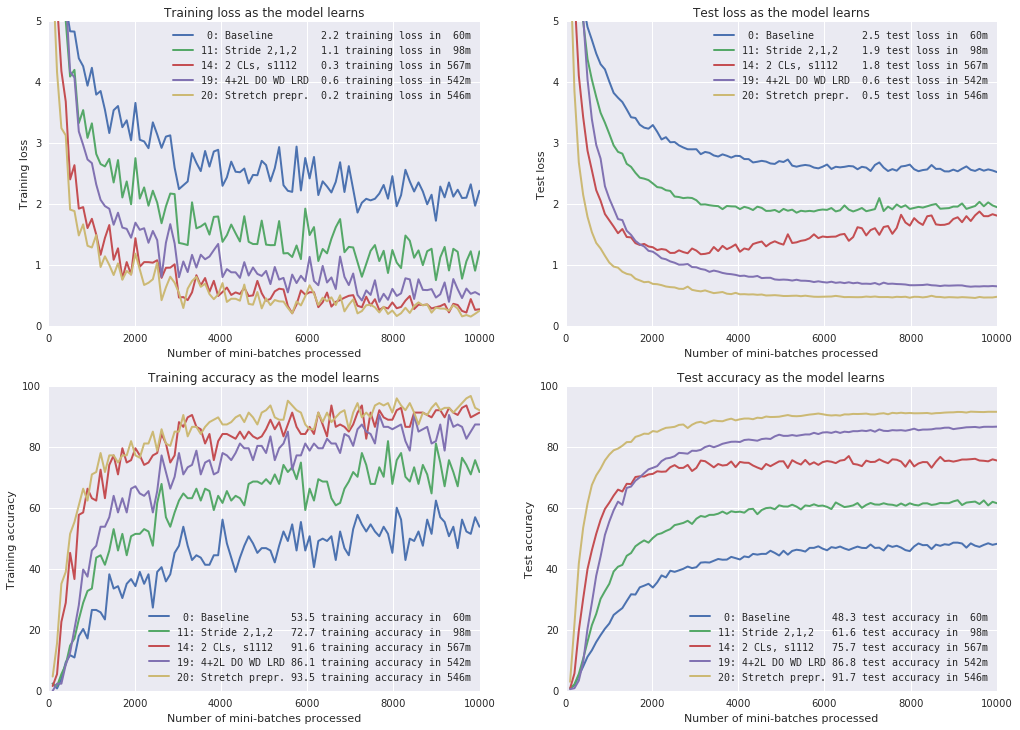

In [27]:
def smooth(x_input, y_input, steps):
  x_output, y_output = [],[]
  counter = 0
  for i in range(len(x_input)//steps):
    x_output.append(sum(x_input[counter:counter+steps]/steps))
    y_output.append(sum(y_input[counter:counter+steps]/steps))
    counter += steps
  return x_output, y_output
    
def run_text_short(results, metric_text, k):
  i, params, _, learning_log, test_accuracy, run_time, _ = results
  maybe_percent = '%' if metric_text[k][-8:] == 'Accuracy' else ''
  metric = np.mean(learning_log[-10:,k+1]) if metric_text[k][:5] == 'Train' else learning_log[-1,k+1]
  return '{:>2d}: {:<14} {:>4.1f}{} {} in {:>3.0f}m'.format(
    i, params[-1], metric, maybe_percent, metric_text[k].lower(), run_time/60)
  
def plot_learning_chart(results_data, smoothing, xlim, ylim, label_flag):
  metric_text = ['Training loss', 'Test loss', 'Training accuracy', 'Test accuracy']
  metric_locs = [1,1,4,4]
  ylims       = [(0,5)]*2 + [(0,100)]*2
  xlims       = None
  fig, ax_list = plt.subplots(2,2, figsize=(17,12))
  fontP = FontProperties()
  fontP.set_size(10)
  fontP.set_family('monospace')
  for k, ax in enumerate(ax_list.flat):
    for results in results_data:
      i, params, long_text, learning_log, test_accuracy, run_time, _ = results
      label = run_text_short(results, metric_text, k) if params[-1] is not None and label_flag != "Full" else long_text
      ax.plot(*smooth(learning_log[:,0], learning_log[:,k+1],smoothing), label=label ,linewidth=2) 
    ax.set_title(metric_text[k] + ' as the model learns')
    ax.set_xlabel("Number of mini-batches processed")
    ax.set_ylabel(metric_text[k])
    if ylims is not None: ax.set_ylim(*ylims[k])
    if xlims is not None: ax.set_xlim(*xlims[k])
    ax.legend(loc = metric_locs[k], prop = fontP)
  plt.show()

plot_learning_chart([results_log[n] for n in [0, 11, 14, 19, 20]], smoothing=1, xlim=None, ylim=None, label_flag = "")
# plot_learning_chart(results_log[-10:], smoothing=5, xlim=None, ylim=None, label_flag = "")
# plot_learning_chart([results_log[0]], smoothing=1, xlim=None, ylim=None, label_flag = "")
# to get the top 10 - 
# plot_learning_chart(sorted(results_log, key = lambda x: x[4])[-10:], smoothing=40, xlim=None, ylim=(75,85), label_flag = "Full")


**4.3 Predict individual samples**

Here we confirm that both the accuracy and loss functions are working as expected with a few randomly selected examples from the last training run.

Sample #: 12731
Pred vs act:   1248 vs 1248 - True


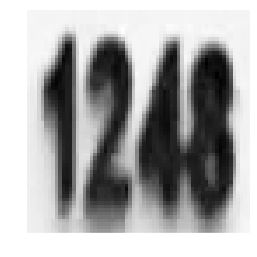

Logits: 
[[ -6.3  18.8   3.4  -0.3   5.5  -7.   -4.3   1.7  -2.6  -4.6   1.5]
 [ -6.4  -3.8  15.8   3.5   2.7  -6.3 -10.7   1.6   2.9   2.1  -3.9]
 [ -1.    3.2  -1.5  -4.7   6.5   0.5   4.5  -8.2   3.8   0.8   1.3]
 [ -0.1  -0.7  -1.    4.    1.4   2.2   3.4  -5.3   8.1   2.4  -0.5]
 [  9.6  -2.8  -7.1  -8.4  -4.7  -2.8  -2.4  -8.   -2.1  -1.2  -2.9]]
Softmax: 
[[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.8  0.   0.1  0.   0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
Losses:        [ 0.   0.   0.2  0.   0. ]
Cross Entropy: [ 0.   0.   0.2  0.   0. ]


In [15]:
test_logits, test_losses, [photo_logits], c_weights = results_log[-1][-1] # the last results; the last argument

def label_to_text(label):
  digit_str  = ['' if a==0 else '0' if a==10 else str(int(a)) for a in label]
  return ''.join(digit_str)

def print_sample_logit(sample, logits_list, labels_array, dataset):
  np.set_printoptions(suppress=True, precision=1, linewidth=100)
  logits        = np.array([digit_logits[sample] for digit_logits in logits_list])
  exp_logits    = np.exp(logits)
  softmax       = exp_logits/np.sum(exp_logits,axis=1,keepdims=True)
  predictions   = np.argmax(logits, axis=1)
  labels        = labels_array[sample,:]
  accuracy      = np.all(predictions == labels)
  losses        = np.array([losses[sample] for losses in test_losses])
  cross_entropy = np.array([-np.log(softmax[i,label]) for i, label in enumerate(labels)])
  print('Sample #: {}'.format(sample))
  print('Pred vs act:   {} vs {} - {}'.format(label_to_text(predictions), label_to_text(labels), accuracy))
  fig,ax = plt.subplots(1)
  ax.imshow(dataset[sample].reshape((64,64)), interpolation='none')
  ax.grid(False)
  ax.axis('off')
  plt.show()
  print('Logits: \n{}'.format(logits))
  print('Softmax: \n{}'.format(softmax))
  print('Losses:        {}'.format(losses))
  print('Cross Entropy: {}'.format(cross_entropy)) # check whether tensorflow's loss matches my cross entropy calculation
  
print_sample_logit(random.randrange(len(test_labels)), test_logits, test_labels, test_dataset)

**4.4 Show accuracy distribution**

How well does the model perform on images containing long and short numbers?

In [16]:
logits_array  = np.array(test_logits).transpose(1,0,2)
predictions   = np.argmax(logits_array, axis=2)

def count_correct_digits(pred_label, actual_label):
  count = 0
  for pred_digit, actual_digit in zip(pred_label, actual_label):
    count += 1 if pred_digit == actual_digit and actual_digit > 0 else 0
  return count

acc_number = np.all(predictions == test_labels, axis=1)
acc_digit  = np.array([count_correct_digits(p, t) for p, t in zip(predictions, test_labels)], dtype='float32')
num_digits = [len(label_to_text(sample)) for sample in test_labels]

d = {'Predicted'  : [label_to_text(sample) for sample in predictions],
     'Actual'     : [label_to_text(sample) for sample in test_labels],
     'Num_digits' : num_digits,
     'Number_acc' : acc_number,
     'Digit_acc'  : acc_digit,
     'Samples'    : np.ones(len(test_labels)),
     'Digits'     : num_digits}

accuracy_data  = pd.DataFrame(d)
accuracy_table = accuracy_data.groupby('Num_digits').sum()
rowtotal = accuracy_table.sum()
rowtotal.name = 'Summary'
accuracy_table = accuracy_table.append(rowtotal)
accuracy_table['Number_acc'] = 100 * accuracy_table['Number_acc'] / accuracy_table['Samples']
accuracy_table['Digit_acc']  = 100 * accuracy_table['Digit_acc'] / accuracy_table['Digits']

print('Number accuracy: {:.2f}%'.format(accuracy_table['Number_acc'].loc['Summary']))
print('Digit accuracy:  {:.2f}%'.format(accuracy_table['Digit_acc'].loc['Summary']))
print('F1 macro score:  {:.2f}%'.format(100*f1_score(accuracy_data['Actual'], accuracy_data['Predicted'], average='macro')))
print('Standard deviation of number accuracy:',np.std(acc_number).round(2))

pd.options.display.float_format = '{:.1f}'.format
print('\nAccuracy by digit:\n',accuracy_table[['Number_acc','Digit_acc','Samples','Digits']])



Number accuracy: 91.34%
Digit accuracy:  96.13%
F1 macro score:  78.59%
Standard deviation of number accuracy: 0.28

Accuracy by digit:
             Number_acc  Digit_acc  Samples  Digits
Num_digits                                        
1                 89.7       91.5    710.0   710.0
2                 92.5       96.0   5193.0 10386.0
3                 92.7       97.1   7977.0 23931.0
4                 78.2       92.7   1108.0  4432.0
5                  0.0       50.0     12.0    60.0
Summary           91.3       96.1  15000.0 39519.0


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**4.5 Show good and bad examples**

What kinds of images are classified well? What images cause the classifier to fail?

Examples of images that were correctly classified


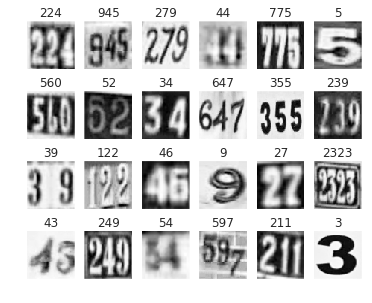

Examples of images that were incorrectly classified


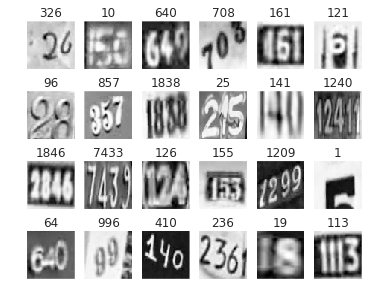

In [17]:
def show_grid_of_numbers(image_data, accuracy_data, correct_or_not, nrows=4, ncols=6):
  indices = accuracy_data.loc[accuracy_data['Number_acc'] == correct_or_not].index.values
  fig, ax_list = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols, nrows*1.2))
  for ax in ax_list.flat:
    sample = indices[random.randrange(indices.shape[0])]
    title   = accuracy_data.iloc[sample]['Predicted']
    ax.imshow(image_data[sample].reshape((64,64)), interpolation='none')
    ax.set_title(title)
    ax.grid(False)
    ax.axis('off')
  plt.show()

print('Examples of images that were correctly classified')
show_grid_of_numbers(test_dataset, accuracy_data, True)

print('Examples of images that were incorrectly classified')
show_grid_of_numbers(test_dataset, accuracy_data, False)


**4.6 Visualise weights**

A key benefit of using a deep neural network is that the main preprocessing steps are learned. Here we visualise the weights as images to see what kind of low level features the network has learned are useful to identify.

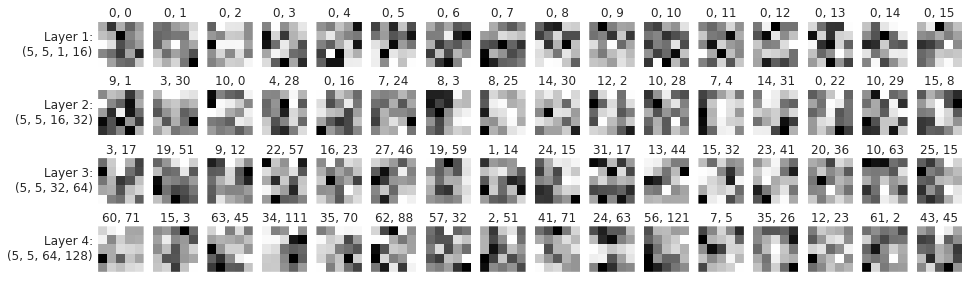

In [18]:
def visualise_weights(weights_list):
  nrows, ncols = len(weights_list), 16
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows*1.1))
  for row, weights in enumerate(weights_list):
#     print('Level {} - {}:'.format(level,weights.shape))
    kernel, _, depth_in, depth_out = weights.shape
    num_images_available = depth_in * depth_out
    for col in range(ncols):
      if num_images_available == ncols: index = col
      else: index = random.randrange(num_images_available)
      in_layer, out_layer = index // depth_out, index % depth_out
      mask = weights[:,:, in_layer, out_layer].reshape((kernel,kernel))
      axes[row][col].imshow(mask, interpolation='none')
      axes[row][col].grid(False)
      axes[row][col].set_title(str(in_layer) + ', ' + str(out_layer))
      axes[row][col].axis('off')
    row_title = 'Layer {}:\n{}'.format(row+1,weights.shape)
    axes[row][0].annotate(row_title, xy=(0, 2), xytext=(-axes[row][0].yaxis.labelpad - 5, 0),
                textcoords='offset points',
                size='large', ha='right', va='center')
    fig.subplots_adjust(left=0.15, top=0.95)
  plt.show()
    
visualise_weights(c_weights)


**4.7 Show performance on test photos**

Check logits array shape is right:  (12, 5, 11)


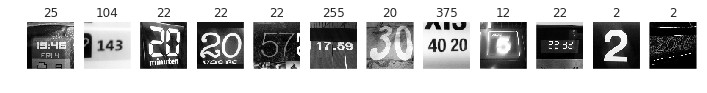

Check logits array shape is right:  (12, 5, 11)


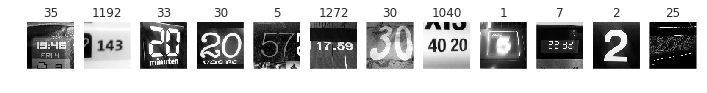

In [19]:
def show_test_photos(runs):
  for run in runs:
    photo_logits = results_log[run][-1][2][0]
    logits_array = np.array(photo_logits).transpose(1,0,2)
    print('Check logits array shape is right: ',logits_array.shape)
    predictions  = np.argmax(logits_array, axis=2)
    fig, ax_list = plt.subplots(nrows=1, ncols=len(test_photos),figsize=(len(test_photos), 1))
    for i, ax in enumerate(ax_list):
      ax.imshow(test_photos[i].reshape((64,64)), interpolation='none')
      ax.set_title(label_to_text(predictions[i]))
      ax.grid(False)
      ax.axis('off')
    plt.show()

show_test_photos([-3, -1])

**Appendix: utilities to reformat the results log**

In [25]:
def run_text_long(params, run_counter, test_accuracy, run_time):
  st, b, (_, conv_l), fc_l, lr, ldr, lds, wd, l_a, do, Nickname = params
  return '{:>2d}: {:>5d} {:>3d} {:<12} {:<11} {:>6} {:>4} {:>4} {:>6} {:>5} {:>3.1f} {:<16} - {:>4.1f}% {:>3.0f}'.format(
          run_counter, st, b,    conv_l, fc_l,   lr,   ldr, lds,   wd,  l_a,  do, Nickname, test_accuracy, run_time/60)

def relabel(run_counter, new_nickname, new_run_count):
  results = results_log[run_counter] 
  i, params, run_text, learning_log, test_accuracy, \
    run_time, output_data          = results

  num_steps, batch_size, conv_layers, fc_layers,\
    initial_rate, learn_decay_rate, learn_decay_steps, \
    weight_decay, algorithm, dropout, nickname             = params

  params = (num_steps, batch_size, conv_layers, fc_layers, \
    initial_rate, learn_decay_rate, learn_decay_steps, \
    weight_decay, algorithm, dropout, new_nickname)
  
  run_text = run_text_long(params, run_counter, test_accuracy, run_time)

  results_log[run_counter] = (new_run_count, params, run_text, learning_log, test_accuracy, \
                              run_time, output_data)

def re_pack_outputs():
  for run_counter in range(len(results_log)):
    i, params, run_text, learning_log, test_accuracy, \
      run_time, test_logits, test_losses, c_weights          = results_log[run_counter]
    results_log[run_counter] = (i, params, run_text, learning_log, test_accuracy, \
                                run_time, (test_logits, test_losses, None, c_weights))

def rename_conv_layers(run_counter, new_conv_name):
  results = results_log[run_counter] 
  i, params, run_text, learning_log, test_accuracy, \
    run_time, output_data          = results

  num_steps, batch_size, conv_layers, fc_layers,\
    initial_rate, learn_decay_rate, learn_decay_steps, \
    weight_decay, algorithm, dropout, nickname             = params

  conv_layer_spec, conv_name = conv_layers
  
  conv_layers = conv_layer_spec, new_conv_name 
    
  params = (num_steps, batch_size, conv_layers, fc_layers, \
    initial_rate, learn_decay_rate, learn_decay_steps, \
    weight_decay, algorithm, dropout, nickname)
  
  run_text = run_text_long(params, run_counter, test_accuracy, run_time)
  
  results_log[run_counter] = (i, params, run_text, learning_log, test_accuracy, \
                              run_time, output_data)
    
# relabel( 0,'2+1 layers', 1)
# relabel(11,'3+1 layers', 10)
# relabel(14,'4+1 layers', 13)
# relabel(19,'4+2 w/ dropout', 20)
relabel(20,'Stretch prepr.', 20)

In [28]:
save_results_log(results_log, 'results.pickle')

results.pickle saved at 10:30
